In [1]:
from torchvision import transforms


train_val_transforms = transforms.Compose(
    [
        transforms.CenterCrop(72),
        transforms.ToTensor(),
        transforms.Normalize([
            0.0004, 0.00041, 0.00041
        ], [
           0.0003, 0.00037, 0.00039
        ])
    ]
)

generated_image_transform = transforms.Compose([
    transforms.Normalize([
            0.0004, 0.00041, 0.00041
        ], [
           0.0003, 0.00037, 0.00039
        ])
])

reverse_image_transform = transforms.Normalize(mean = [
            -0.0004/0.0003, -0.00041/0.00037, -0.00041/0.00039
        ], std = [
           1/0.0003, 1/0.00037, 1/0.00039
        ])


MODEL_DIR = "../models"
DATASET_DIR = "../datasets"
DATASET_NAME = "img_dataset.csv"
IMGS_DIR = r"D:\WrapperRL_AAAI\datasets\generated_images\log_all_features"

In [2]:
from torch.utils.data import Dataset
# import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

class CustomImageLoadingDataset(Dataset):
    
    def __init__(self, csv, transform):
        self.csv = csv
        self.img_paths = self.csv.loc[:, 'img'].values
        self.img_labels = self.csv.loc[:, 'process'].values
        self.transform = transform
        
    def __len__(self):
        return self.csv.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        new_img_path = f"{IMGS_DIR}/{img_path}"

        label = self.img_labels[idx]
        
        img = plt.imread(new_img_path)
        img = Image.fromarray((img * 255).astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)
        img = torch.div(img, 255)
        
            
        return img, label, new_img_path

In [3]:
import torch
import torch.nn as nn

class eca_layer(nn.Module):
    
    def __init__(self, channel, k_size = 3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size = k_size, padding = (k_size - 1) // 2, bias = False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x), y
    
import torch
import torch.nn as nn

class Self_Attn(nn.Module):
    
    def __init__(self, in_dim, activation):
        super(Self_Attn, self).__init__()
        self.channel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 8, kernel_size = 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 8, kernel_size = 1)        
        self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)
        
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -1)
        
    
    def forward(self, x):
        """
            inputs: 
                x: input feature maps (B X C X W X H)
                
            returns:
                out: self attention value + input_feature
                attention: B X N X N (N is Width * Height)
        """
        
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1))
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        
        return out, attention

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Attn(nn.Module):
    
    def __init__(self):
        super(CNN_Attn, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.self_attn1 = eca_layer(3)

        
        self.attn1 = Self_Attn(20, 'relu')
        self.attn2 = Self_Attn(30, 'relu')
        self.fc1 = nn.Linear(750, 1)
        
    def forward(self, x):
        x, channel_x = self.self_attn1(x)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x, p1 = self.attn1(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x, p2 = self.attn2(x)
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        out = self.fc1(x)
        
#         return out, p1, p2, channel_x
        return torch.sigmoid(out), p1, p2, channel_x
        
    

In [5]:
import pandas as pd

model = CNN_Attn()
DATASET_PATH = f"{DATASET_DIR}/{DATASET_NAME}"
images_df = pd.read_csv(DATASET_PATH, index_col = [0])

In [6]:
print(images_df.shape)

(86242, 3)


In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(images_df, test_size = 0.2)

In [15]:
print(train_df.shape, test_df.shape)

(68993, 3) (17249, 3)


In [16]:
from torch.utils.data import DataLoader

training_dataset = CustomImageLoadingDataset(train_df, train_val_transforms)
training_loader = DataLoader(training_dataset, batch_size = 16, shuffle = True)


testing_dataset = CustomImageLoadingDataset(test_df, train_val_transforms)
testing_loader = DataLoader(testing_dataset, batch_size = 16, shuffle = True)

In [81]:
from torch.optim import Adam
import numpy as np
from tqdm.notebook import tqdm

def train_model(model, train_data, nb_epochs = 10):
    model.train()
    loss_fcn = nn.BCELoss()
    
    optimizer = Adam(model.parameters(), lr = 1e-4)
    curr_loss = np.array([])
    
    for epoch in tqdm(range(nb_epochs)):
        for idx, img_data in enumerate(train_data):
            optimizer.zero_grad()
            img, label, _ = img_data
            res, _, _, _ = model(img)
            res= res.float()
#             res = torch.squeeze(res)
            res = res.reshape((-1, ))
            label = label.float()

            loss = loss_fcn(res, label)

            loss.backward()
            optimizer.step()

            curr_loss = np.append(curr_loss, loss.detach().numpy())
        
    return curr_loss

In [82]:
def evaluate(model, test_loader):
    model.eval()
    ground_truth, predictions = np.array([]), np.array([])
    
    with torch.no_grad():
        for img_data in test_loader:
            img, label, _  = img_data
            preds, _, _, _ = model(img)
            preds = preds.round()
            
            ground_truth = np.append(ground_truth, label.detach().numpy())
            predictions = np.append(predictions, preds.detach().numpy())
    
    
    return ground_truth, predictions

In [83]:
model = CNN_Attn()

In [84]:
set_losses = train_model(model, training_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [85]:
ground_truth, predictions = evaluate(model, testing_loader)

In [86]:
from sklearn.metrics import classification_report

print(classification_report(
    ground_truth,
    predictions
))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1425
         1.0       1.00      1.00      1.00     15824

    accuracy                           1.00     17249
   macro avg       0.98      1.00      0.99     17249
weighted avg       1.00      1.00      1.00     17249



In [88]:
print(len(training_loader))

4313


In [89]:
print(len(set_losses))

43130


In [92]:
df_losses = pd.DataFrame(columns = ['loss'])
df_losses['loss'] = set_losses
df_losses.head()

,loss
0,0.717997
1,0.707796
2,0.702777
3,0.705988
4,0.699487


In [ ]:
df_losses.rolling(10)

In [101]:
rolling_avg = df_losses['loss'].rolling(40)

In [102]:
print(rolling_avg.mean().dropna())

39       0.599970
40       0.592021
41       0.586354
42       0.581338
43       0.575617
           ...   
43125    0.027169
43126    0.027167
43127    0.027079
43128    0.027318
43129    0.025447
Name: loss, Length: 43091, dtype: float64


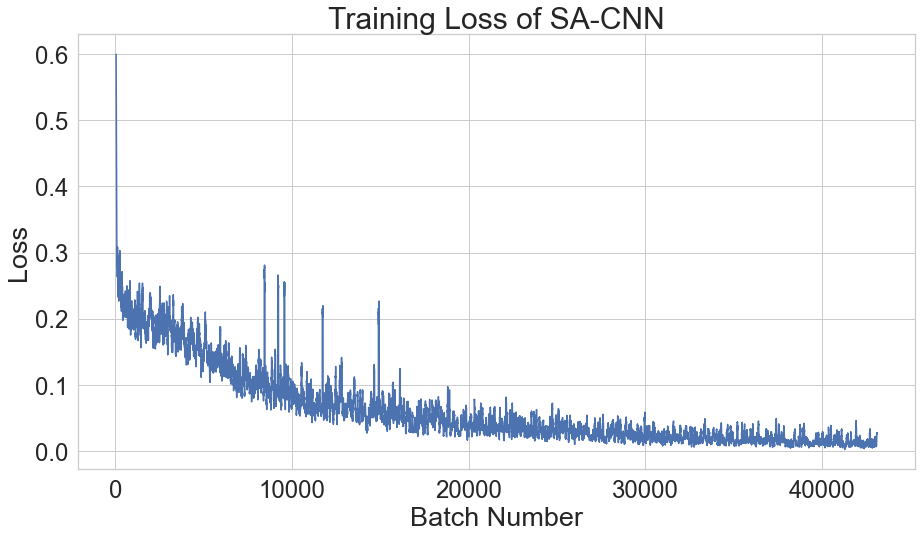

In [108]:
import seaborn as sns

sns.set_theme(style = 'whitegrid')
fig, ax = plt.subplots(figsize = (15, 8))
plt.plot(rolling_avg.mean().dropna())
plt.tick_params(labelsize = 24)
plt.ylabel("Loss", fontsize = 27)
plt.xlabel("Batch Number", fontsize = 27)
plt.title("Training Loss of SA-CNN", fontsize = 30)
plt.savefig("../figures/loss_SA_CNN.png", pad_inches = 0, bbox_inches = 'tight')
plt.savefig("../figures/loss_SA_CNN.eps", pad_inches = 0, bbox_inches = 'tight')